# __Step 6.1: Arabodopsis-related topic over time__

Goals here:
- Model topics for docs mentioning Arabidopsis
- Model Arabidopsis topics over time

Issues:
- 10/4/22: 
  - Run BERTopic and get `RuntimeError: CUDA error: no kernel image is available for execution on the device`.
    - Reinstall torch following advices from [here](https://github.com/NVlabs/stylegan2-ada-pytorch/issues/6) for example
    - `conda install pytorch torchvision torchaudio cudatoolkit=11.6 -c pytorch -c conda-forge`
  - Once updating torch, run into problem that numba requires numpy <=1.21
    - `conda install numpy=1.21`
  - Get `AttributeError: 'BERTopic' object has no attribute 'generate_topic_labels'`
    - Update BERTopic: `pip install --upgrade bertopic`
  - Get `ImportError: cannot import name 'DatasetInfo' from 'huggingface_hub.hf_api'`
    - Update huggingface_hub
  - Because BERTopic is updated, the c-tf-idf matrix name is changed. This is not changed for earlier codes.

## ___Set up___

### Module import

In bertopic environment

In [1]:
import re, pickle, os, torch, csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.graph_objects as go

from pathlib import Path
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from xlsxwriter.workbook import Workbook
from datetime import datetime
from bisect import bisect
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
from scipy.interpolate import interp1d
from shutil import copy
from dateutil.relativedelta import relativedelta

In [2]:
torch.cuda.is_available(), torch.__version__

(True, '1.12.1')

### Key variables

In [3]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "6_topic_model_arabidopsis/"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus with date and other info
dir2        = proj_dir / "2_text_classify//2_5_predict_pubmed"
corpus_file = dir2 / "corpus_plant_421658.tsv.gz"

# Species match data
dir5               = proj_dir / "5_species_over_time/"
viridi_offspr_file = dir5 / "viridiplantae_offspring_names.pickle" 
match_csr_file     = dir5 / "match_csr.pickle"

# BERT model to use
model_name     = "allenai/scibert_scivocab_uncased"
model_name_mod = "-".join(model_name.split("/"))

# the target term
target = "Arabidopsis"

## outputs for topic modeling
# path for the corpus for the target (i.e., Arabidopsis)
corpus_target_file = work_dir / "corpus_arabidopsis.tsv.gz"
# generated during bertopic run
docs_clean_file  = work_dir / f"docs_clean_{target}.pickle"
emb_file         = work_dir / f"embeddings_{target}_scibert.pickle"
topic_model_file = work_dir / f"topic_model_{target}_{model_name_mod}"
topics_file      = work_dir / f"topics_{target}_{model_name_mod}.pickle"
probs_file       = work_dir / f'probs_{target}_{model_name_mod}.pickle'
topic_model_updated_file = work_dir / \
                              f"topic_model_update_{target}_{model_name_mod}"

## outputs for topic model analysis
top_50_terms_file = work_dir / f'top_50_terms_per_topic_{target}.pickle'
top_50_terms_xlsx = work_dir / f'top_50_terms_per_topic_{target}.xlsx'
topic_label_file  = work_dir / f"topic_labels_{target}.txt"
rep_docs_file     = work_dir / f"topic_rep_docs_{target}.tsv"

# Put the top 50 term info into different tsv files in the top_50 folder
top_50_dir = work_dir / "top_50"
top_50_dir.mkdir(parents=True, exist_ok=True)

## output for topic over time analysis
# Creat a folder to store c-tf-idf matrix for each timestamp bin
ctfidf_dir = work_dir / "ctfidf_over_time"
ctfidf_dir.mkdir(parents=True, exist_ok=True)

# Create a folder to store topic over time graph for each topic
tot_graph_dir = work_dir / 'tot_graphs'
tot_graph_dir.mkdir(parents=True, exist_ok=True)

# output for lowess fit
dir_lowess = work_dir / "_lowess"
dir_lowess.mkdir(parents=True, exist_ok=True)

# for selected files
dir_lowess_sel = dir_lowess / "_selected"
dir_lowess_sel.mkdir(parents=True, exist_ok=True)

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Get all Arabidopsis records___

### Get match_csr column that is for Arabidopsis

In [4]:
# load the saved csr
with open(match_csr_file, "rb") as f:
  match_csr = pickle.load(f)

# load viridiplantae offspring names that is the same order as match_csr
with open(viridi_offspr_file, "rb") as f:
  viridi_offspr_names = pickle.load(f)

In [5]:
# Check dimension
match_csr.shape, len(viridi_offspr_names)

((421658, 26782), 26782)

In [6]:
target_idx = viridi_offspr_names.index(target)
target_idx

22612

In [7]:
# Get indicues of non-zero elements
#https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html
target_match_arr = match_csr[:,target_idx].toarray().ravel()
target_match_idx = np.nonzero(target_match_arr)[0]

# Check datatype, shape, and total (ok)
type(target_match_arr), len(target_match_arr), np.sum(target_match_arr)

(numpy.ndarray, 421658, 50346)

In [8]:
len(target_match_idx), target_match_idx[:5]

(50346, array([ 994, 1725, 2524, 3022, 3032]))

### Get the corpus dataframe for records mentioning Arabidopsis

In [10]:
# Read corpus file
corpus_all = pd.read_csv(corpus_file, compression='gzip', sep='\t')

In [11]:
# Make sure the corpus contain Arabidopsis, test the 1st 1000
#https://www.statology.org/pandas-select-rows-by-index/
test1000     = corpus_all.loc[target_match_idx[:1000]]['txt']
count_found = 0
for txt in test1000:
  if "Arabidopsis" in txt:
    count_found += 1

print(count_found)

1000


In [12]:
# Get the dataframe for Arabidopsis
if corpus_target_file.is_file():
  print("  load corpus_target_file")
  corpus_target = pd.read_csv(corpus_target_file, sep='\t', compression='gzip')
else:
  print("  generate corpus_target_file")
  corpus_target = corpus_all.loc[target_match_idx]
  corpus_target.to_csv(corpus_target_file, sep='\t', compression='gzip')
  
print(corpus_target.shape)

  load corpus_target_file
(50346, 12)


## ___Topic modeling___

Codes modified from `script_4_1_topic_model_v2.py` and `script_4_2_outlier_assign.ipynb`

### Pre-processing texts

In [32]:
def clean_text(x, stop_words_dict):
    x = str(x)
    x = x.lower()
    # Replace any non-alphanumric characters of any length
    # Q: Not sure what the # character do.
    x = re.sub(r'#[A-Za-z0-9]*', ' ', x)
    # tokenize and rid of any token matching stop words
    tokens = word_tokenize(x)
    x = ' '.join([w for w in tokens if not w in stop_words_dict])
    return x
    
print("Pre-processing docs")
if docs_clean_file.is_file():
  print("  load processed docs")
  with open(docs_clean_file, "rb") as f:
    docs_clean = pickle.load(f)
else:
  print("  read corpus and process docs")
  corpus_target_df = pd.read_csv(corpus_target_file, sep='\t', compression='gzip')
  
  docs       = corpus_target_df['txt']
  stop_words = stopwords.words('english')
  stop_words_dict = {}
  for i in stop_words:
    stop_words_dict[i] = 1

  docs_clean = []
  for doc_idx in tqdm(range(len(docs))):
    doc = docs[doc_idx]
    docs_clean.append(clean_text(doc, stop_words_dict))
  with open(docs_clean_file, "wb") as f:
    pickle.dump(docs_clean, f)

len(docs_clean)

Pre-processing docs
  load processed docs


50346

### Generate embeddings

In [33]:
# Generate embeddings
if emb_file.is_file():
  print("Load embeddings")
  with open(emb_file, "rb") as f:
    embeddings = pickle.load(f)
else:
  print("Generate embeddings")
  emb_model  = SentenceTransformer(model_name)
  embeddings = emb_model.encode(docs_clean, show_progress_bar=True)
  # Output embeddings
  with open(emb_file, "wb") as f:
    pickle.dump(embeddings, f)

Load embeddings


### Run BERTopic

#### Set parameters

In [ ]:
# HDBSCAN clustering setting
min_cluster_size         = 100 # This is 500 for the full dataset run
metric                   = 'euclidean' 
cluster_selection_method ='eom' 
prediction_data          = True 
min_samples              = 5

# BERTopic setting
calculate_probabilities = True
n_neighbors             = 10  
nr_topics               = 500
n_gram_range            = (1,2)

#### Initialize HDBSCAN

For reducing outliers, following [this instruction](https://maartengr.github.io/BERTopic/faq.html#how-do-i-reduce-topic-outliers)
- Also see [HDBSCAN doc](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html#what-about-different-metrics)
- Comparison of [distance metrics](https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html)

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, 
                        metric=metric, 
                        cluster_selection_method=cluster_selection_method, 
                        prediction_data=prediction_data, 
                        min_samples=min_samples)

#### Intialize and train topic model

In [ ]:
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                       calculate_probabilities=calculate_probabilities,
                       n_gram_range=n_gram_range,
                       nr_topics=nr_topics,
                       verbose=True)

In [ ]:
topics, probs = topic_model.fit_transform(docs_clean,
                                          embeddings)

#### Save model, topics, and probability

In [ ]:
# I already save the embeddings, so won't save it again
topic_model.save(topic_model_file)

with open(topics_file, "wb") as f:
    pickle.dump(topics, f)

with open(probs_file, "wb") as f:
  pickle.dump(probs, f)

#### Load model and probabilities

This is more for running topic modeling on the much larger corpus. Here the targeted corpus is much smaller. But keep this anyway.

In [35]:
# Load topic model
topic_model = BERTopic.load(topic_model_file)

# load prob
with open(probs_file, "rb") as f:
  probs = pickle.load(f)

In [36]:
topic_info = topic_model.get_topic_info()
topic_info.head(), topic_info.tail()

(   Topic  Count                                       Name
 0     -1  20207          -1_arabidopsis_plants_plant_genes
 1      0    101   0_spaceflight_microgravity_space_gravity
 2      1    118  1_ptdins_inositol_phosphatidylinositol_p2
 3      2    129    2_heterotrimeric_gprotein_signaling_rop
 4      3   1034          3_transformation_tdna_gene_system,
     Topic  Count                                        Name
 60     59    266          59_floral_genes_development_flower
 61     60    402      60_flowering_ft_floral_flowering locus
 62     61    425  61_circadian_clock_circadian clock_rhythms
 63     62    104                    62_ndh_psii_por_assembly
 64     63    381               63_psii_photosystem_light_psi)

## ___Outlier assignments___

Modified from `script_4_2_outlier_assign.ipynb`

### Assignments

In [37]:
# 95 precentile probability value as threshold
probability_threshold = np.percentile(probs, 95)
new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]

In [38]:
# Unassigned doc number
n_unassigned = pd.Series(new_topics).value_counts().loc[-1]
n_unassigned/len(new_topics)

0.04057919199141938

### Update topics


In [ ]:
# update topic based on new topics
topic_model.update_topics(docs_clean, new_topics)

In [ ]:
# Update topic frequencies
documents = pd.DataFrame({"Document": docs_clean, "Topic": new_topics})
topic_model._update_topic_size(documents)
topic_model.save(topic_model_updated_file)

### Get updated topic info

In [13]:
# Load topic model
topic_model = BERTopic.load(topic_model_updated_file)

In [14]:
topic_info = topic_model.get_topic_info()
topic_info[:5]

,Topic,Count,Name
0,-1,2043,-1_arabidopsis_genes_protein_plant
1,0,127,0_spaceflight_microgravity_space_gravity
2,1,154,1_ptdins_inositol_phosphatidylinositol_p2
3,2,218,2_heterotrimeric_gprotein_signaling_protein
4,3,1103,3_transformation_gene_tdna_plants


In [16]:
n_total     = np.sum(topic_info['Count'].values)
n_outlier   = topic_info['Count'][0]
n_in_topics = n_total - n_outlier
n_in_topics, n_in_topics/n_total*100

(48303, 95.94208080085807)

## ___Topic model analysis___

### Topic size distribution

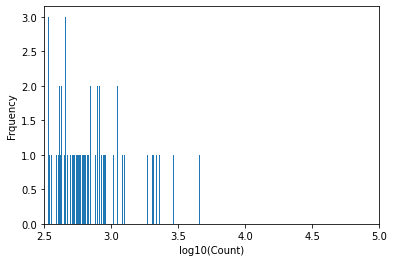

In [17]:
plt.hist(np.log10(topic_info["Count"]), bins=200)
plt.xlabel("log10(Count)")
plt.ylabel("Frquency")
plt.xlim(2.5,5)
plt.savefig(work_dir / f"fig6_topic_count_dist_{target}.pdf")

### Topic-term matrix for top 50 terms

In [18]:
# Sparse matrix with topics as rows and features (i.e. terms) as columns, 
# values are c-Tf-idf
# 10/4/22: The updated BERTopic refer to the c_tf_idf matrix differently with an
#   extra '_' at the end
#topic_term_matrix = topic_model.c_tf_idf
topic_term_matrix = topic_model.c_tf_idf_
type(topic_term_matrix), topic_term_matrix.shape

(scipy.sparse._csr.csr_matrix, (65, 3118159))

In [19]:
# A list of features (terms)
terms = topic_model.vectorizer_model.get_feature_names()

# Get top 50 terms
top_50 = {} # {topic:[top50_idx_list, top50_c-tf-idf_list, to50_feat_list]}

# Skip the outlier topic, named the variable topic_plus1 because the topic
# index is -1 from the index in the topic_term_marix.
for topic_plus1 in tqdm(range(1, topic_term_matrix.shape[0])):
  row     = topic_term_matrix.getrow(topic_plus1).toarray()[0].ravel()

  # The following two lines sorted from low to high
  t50_idx = list(row.argsort()[-50:])
  t50_val = list(row[row.argsort()[-50:]])

  t50_fea = [terms[i] for i in t50_idx]
  top_50[topic_plus1-1] = [t50_idx, t50_val, t50_fea]

100%|██████████| 64/64 [00:09<00:00,  6.68it/s]


In [20]:
# Save the top 50 terms
with open(top_50_terms_file, 'wb') as f:
  pickle.dump(top_50, f)

In [21]:
topic_labels = topic_model.generate_topic_labels(nr_words=10,
                                                 topic_prefix=True,
                                                 separator='|')

In [22]:
# Save top terms for different topics into an xlsx file
xlsx      = Workbook(top_50_terms_xlsx)

# Do not output outlier
topic_label_df = pd.DataFrame(topic_labels[1:])
topic_label_df.columns = ["label"]
topic_label_df.to_csv(topic_label_file, sep='\t')

worksheet = xlsx.add_worksheet("topic_label")
read_tsv = csv.reader(open(topic_label_file,'r',encoding='utf-8'),delimiter='\t')
for row, data in enumerate(read_tsv):
  worksheet.write_row(row, 0, data)

In [23]:
# Incude the representative doc in a worksheet
rep_docs    = topic_model.get_representative_docs()
rep_docs_df = pd.DataFrame.from_dict(rep_docs, orient='index',
                                  columns=['doc1', 'doc2', 'doc3'])
rep_docs_df.to_csv(rep_docs_file, sep='\t')

worksheet = xlsx.add_worksheet("representative docs")
read_tsv = csv.reader(open(rep_docs_file,'r',encoding='utf-8'),delimiter='\t')
for row, data in enumerate(read_tsv):
  worksheet.write_row(row, 0, data)

In [24]:
# Put the top 50 term info into different tsv files in the top_50 folder
# Output individual tsv files and put tsv into xlsx
for topic in top_50:
  topic_file = top_50_dir / f"topic_{topic}.tsv"
  # The nested list has index, c-tf-idf, and feature as rows. So it is transposed
  # to have the rows as columns. The iloc bit is to reverse the order so higher
  # c-tf-idf entries are on top.
  topic_df = pd.DataFrame(top_50[topic]).transpose().iloc[::-1]
  topic_df.columns = ["index", "c-tf-idf", "feature"]
  topic_df.to_csv(topic_file, sep='\t')

  # Save to xlsx
  worksheet = xlsx.add_worksheet(f"{topic}")
  read_tsv  = csv.reader(open(topic_file, 'r',encoding='utf-8'),delimiter='\t')
  for row, data in enumerate(read_tsv):
    worksheet.write_row(row, 0, data)

xlsx.close()

## ___Records per year and timestamp bins___

Code modified from `script_4_4_topic_over_time.ipynb`

### Plot records per year

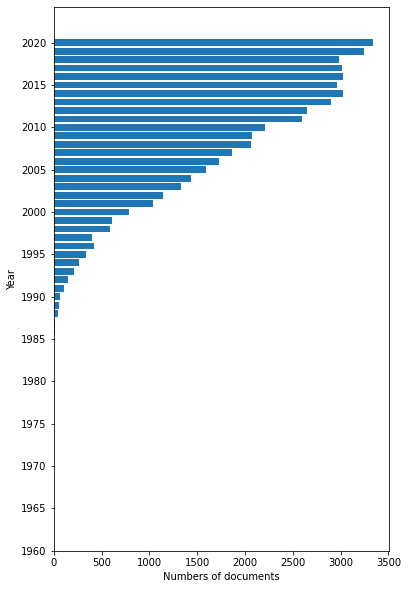

In [25]:
# Get pandas series dates
dates = corpus_target['Date']

ts_for_plot = [] # timestamps for plotting
docs_yr     = [] # a list of years for generating bar graph later
early_doc   = {} # {year: count}
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  # docs from the same year has the same timestamp
  yr = int(yr)
  docs_yr.append(yr)

  # Create 
  if yr not in early_doc:
    early_doc[yr] = 1
  else:
    early_doc[yr]+= 1

  # Set year before 1970 as 1969.
  if yr < 1970:  
    yr = 1969

  # Set year after 2020 as 2020. There are 58 instances
  if yr > 2020:  
    yr = 2020

  dt   = datetime(yr, 1, 1)
  ts   = dt.timestamp()
  ts_for_plot.append(ts)

# array with number of records per year
docs_year_array = np.unique(np.array(docs_yr), return_counts=True)

# dataframe with counts per year
docs_year_df    = pd.DataFrame(docs_year_array[1], columns=["Count"],
                               index=docs_year_array[0])

# without log
plt.figure(figsize=(6,10))
plt.barh(docs_year_array[0], docs_year_array[1])
plt.ylabel('Year')
plt.xlabel('Numbers of documents')
plt.yticks(range(1960, 2021, 5))
plt.savefig(work_dir / f'figure6_num_docs_per_year_{target}.pdf')

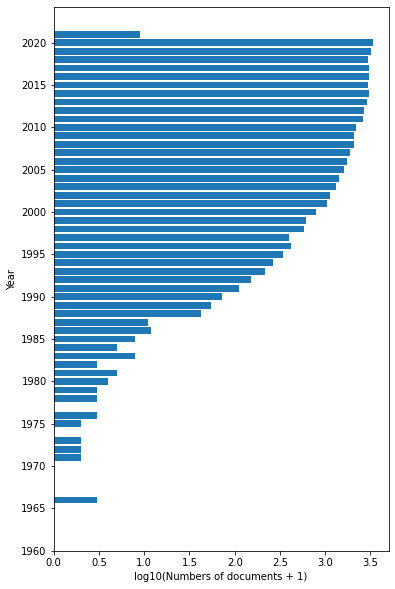

In [26]:
# logged
plt.figure(figsize=(6,10))
plt.barh(docs_year_array[0], np.log10(docs_year_array[1]+1))
plt.ylabel('Year')

# +1 so the x-axis value is not zero.
plt.xlabel('log10(Numbers of documents + 1)')
plt.yticks(range(1960, 2021, 5))
plt.savefig(work_dir / 'figure6_num_docs_per_year_{target}_logged.pdf')

### Get the binned timestamp values

Divide into 20 bins

In [27]:
# Turn all dates into timestamps 
ts_for_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()
  ts_for_bins.append(ts)
  
ts_for_bins.sort()

In [28]:
# bin size
bin_num  = 20
bin_size = int(len(ts_for_bins)/bin_num)

# index values of every 1/bin_num*100 percentile (because the data is broken 
# into parts=bin_num)
bin_idxs = [idx for idx in range(0, len(ts_for_bins), bin_size)]

# timestamp values at bin_idxs
bin_timestamps = [ts_for_bins[idx] for idx in bin_idxs]

# Modify the last value to be the max timestamp value + 1. This is otherwise
# because of the bin_size is rounded down the last value be smaller than the max
# timestamp values. Also, +1 to the max value, otherwise, the last entries will
# be in its own bin.
max_timestamp      = max(ts_for_bins) + 1
bin_timestamps[-1] = max_timestamp

# dates correspond to the different timestamp
bin_dates      = [datetime.fromtimestamp(ts) for ts in bin_timestamps]

# Put idx, timestamp, and date into a dataframe and save it.
bin_df         = pd.DataFrame(list(zip(bin_idxs, bin_timestamps, bin_dates)),
            columns=['bin_start_idx', 'bin_start_timestamp', 'bin_start_date'])
bin_df.to_csv(work_dir / f"table6_bin_timestamp_date_{target}.tsv", sep='\t')

In [29]:
bin_df.head(), bin_df.tail()

(   bin_start_idx  bin_start_timestamp bin_start_date
 0              0        -1.211148e+08     1966-03-01
 1           2517         9.030672e+08     1998-08-14
 2           5034         1.006405e+09     2001-11-22
 3           7551         1.071551e+09     2003-12-16
 4          10068         1.124942e+09     2005-08-25,
     bin_start_idx  bin_start_timestamp      bin_start_date
 16          40272         1.509509e+09 2017-11-01 00:00:00
 17          42789         1.536034e+09 2018-09-04 00:00:00
 18          45306         1.561176e+09 2019-06-22 00:00:00
 19          47823         1.585714e+09 2020-04-01 00:00:00
 20          50340         1.609477e+09 2021-01-01 00:00:01)

### Generate the binned timestamps

In [30]:
# Assign new timestamps based on the bin timestamp values
ts_in_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()

  bin_idx = bisect(bin_timestamps, ts)

  if bin_idx < len(bin_timestamps):
    ts2     = bin_timestamps[bin_idx]
  # Deal with the last bin
  else:
    ts2     = datetime(2022, 12, 31).timestamp()
  ts_in_bins.append(ts2) 

len(ts_in_bins) # Expect 50346, the number of Arabidopsis docs

50346

## ___Run topics_over_time___

### Set up

In [39]:
docs             = docs_clean
topics           = new_topics # 10/27: an earlier run did not update this
timestamps       = ts_in_bins
nr_bins          = 20
global_tuning    = 0
evolution_tuning = 1

# Get the global (i.e., based on the whole timef rame) ctfidf values
global_c_tf_idf = normalize(topic_model.c_tf_idf_, axis=1, norm='l1', copy=False)
# Construct a documents dataframe
documents = pd.DataFrame({"Document": docs, "Topic": topics, 
                          "Timestamps": timestamps})

In [40]:
# Get topic names, ordered and then get their indices, 0-based
all_topics = sorted(list(documents.Topic.unique()))
all_topics_indices = {topic: index for index, topic in enumerate(all_topics)}

# 53 topics, index=0 is the outlier
len(all_topics), all_topics[0], type(all_topics_indices), all_topics_indices[-1]

(65, -1, dict, 0)

In [41]:
# Bin values into discrete intervals
ts_bins   = [] # a list of tuples showing the bin range (+/-1 of the unique val)
for ts in timestamps:
  ts_bins.append(pd.Interval(left=ts-1, right=ts+1))

# Add the bin info as a new column in documents df
documents["Bins"] = ts_bins
# Add timestamp column
documents["Timestamps"] = documents.apply(lambda row: row.Bins.left, 1)
documents.head(2)

,Document,Topic,Timestamps,Bins
0,somatic mosaicism plants special reference som...,3,903067199.0,"(903067199.0, 903067201.0]"
1,[ growth arabidopsis thaliana embryos followin...,58,903067199.0,"(903067199.0, 903067201.0]"


In [42]:
# Sort documents in chronological order
documents  = documents.sort_values("Timestamps")

# Unique timestamps
ts_unique = documents.Timestamps.unique()
ts_unique

array([9.03067199e+08, 1.00640520e+09, 1.07155080e+09, 1.12494240e+09,
       1.17082440e+09, 1.21203360e+09, 1.25177760e+09, 1.28763360e+09,
       1.31796000e+09, 1.34880480e+09, 1.37653920e+09, 1.40237280e+09,
       1.42941600e+09, 1.45646280e+09, 1.48307400e+09, 1.50950880e+09,
       1.53603360e+09, 1.56117600e+09, 1.58571360e+09, 1.60947720e+09])

### Run modified topics_over_time code

evolution_tuning=1, global_tuning=0

In [43]:
# For each unique timestamp, create topic representations
topics_over_time = []
for index, timestamp in enumerate(tqdm(ts_unique)):
  #print(index, timestamp)
  # Calculate c-TF-IDF representation for a specific timestamp
  selection = documents.loc[documents.Timestamps == timestamp, :]
  
  docs_per_toc = selection.groupby(['Topic'], as_index=False).agg(
                                {'Document': ' '.join, "Timestamps": "count"})
  c_tf_idf, words = topic_model._c_tf_idf(docs_per_toc, fit=False)
  
  if global_tuning or evolution_tuning:
    c_tf_idf = normalize(c_tf_idf, axis=1, norm='l1', copy=False)

  # Fine-tune the c-TF-IDF matrix at timestamp t by averaging it with the 
  # c-TF-IDF matrix at timestamp t-1
  if evolution_tuning and index != 0:
    curr_toc         = sorted(list(docs_per_toc.Topic.values))
    overlap_toc      = sorted(list(set(prev_toc).intersection(set(curr_toc))))
    curr_overlap_idx = [curr_toc.index(topic) for topic in overlap_toc]
    prev_overlap_idx = [prev_toc.index(topic) for topic in overlap_toc]

    c_tf_idf.tolil()[curr_overlap_idx] = \
      ((c_tf_idf[curr_overlap_idx] + prev_c_tf_idf[prev_overlap_idx]) / 2.0).tolil()

  # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
  # by simply taking the average of the two
  #if global_tuning:
  #  selected_topics = [all_topics_indices[topic] \
  #                                      for topic in docs_per_toc.Topic.values]
  #  c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

  # Extract the words per topic
  labels = sorted(list(docs_per_toc.Topic.unique()))
  words_per_toc = topic_model._extract_words_per_topic(words, c_tf_idf, labels)
  topic_frequency = pd.Series(docs_per_toc.Timestamps.values,
                                index=docs_per_toc.Topic).to_dict()
  # Fill dataframe with results
  topics_at_timestamp = [(topic,
                          ", ".join([words[0] for words in values][:5]),
                          topic_frequency[topic],
                          timestamp) for topic, values in words_per_toc.items()]
  topics_over_time.extend(topics_at_timestamp)

  if evolution_tuning:
    prev_toc = sorted(list(docs_per_toc.Topic.values))
    prev_c_tf_idf = c_tf_idf.copy()

  # Save the word list if this is the 1st timestamp
  if index == 0:
    word_file = ctfidf_dir / f"word_list_{len(words)}.pickle"
    with open(word_file, 'wb') as f:
      pickle.dump(words, f)

  # Save the ctfidf values
  ctfidf_file = ctfidf_dir / f'ctfidf_{index}_no_globatune.pickle'
  with open(ctfidf_file, "wb") as f:
    pickle.dump(c_tf_idf, f)

  # Save index and topic name for cross-referencing in ctfidf_file
  toc_index_file = ctfidf_dir / f"ctfidf_{index}_toc_index.tsv"
  docs_per_toc['Topic'].to_csv(toc_index_file, sep='\t')


100%|██████████| 20/20 [06:05<00:00, 18.28s/it]


In [44]:
topics_over_time = pd.DataFrame(topics_over_time, 
                          columns=["Topic", "Words", "Frequency", "Timestamp"])
tot_df_file = work_dir / \
                      f"table6_topics_over_time_df_no_global_tune_{target}.tsv"
topics_over_time.to_csv(tot_df_file, sep='\t')
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"protein, gene, arabidopsis, binding, sequence",115,9.030672e+08
1,0,"spaceflight, space, flight, seeds, plants",31,9.030672e+08
2,1,"pldgamma, pld, pldalpha, pldbeta, nad kinase",7,9.030672e+08
3,2,"7tm, 7tm receptors, heterotrimeric, small prot...",2,9.030672e+08
4,3,"ac, tdna, transformation, gene, excision",164,9.030672e+08
...,...,...,...,...
1290,59,"flower, floral, flowering, development, stamen",24,1.609477e+09
1291,60,"flowering, flowering time, time, flowering loc...",36,1.609477e+09
1292,61,"clock, circadian, circadian clock, rhythms, di...",17,1.609477e+09
1293,62,"assembly, trx, photosynthesis, oxa2a, pql3",17,1.609477e+09


### Topic over time plot

Customize [BERTopic/bertopic/plotting/_topics_over_time.py](https://github.com/MaartenGr/BERTopic/blob/master/bertopic/plotting/_topics_over_time.py):
- BERTopic version is 0.12.0, different from what I started with 0.9.4.
- The function to modify is `visualize_topics_over_time`.

In [45]:
def visualize_tot_mod(topic_model, topics_over_time, topics=None, 
                      normalize_frequency=False, width=1000, height=400):

  colors = ["#56B4E9", "#E69F00", "#009E73", "#F0E442", "#D55E00", "#0072B2", 
            "#CC79A7"]

  # Select topics
  if topics:
    selected_topics = topics
  else:
    selected_topics = topic_model.get_topic_freq().Topic.values

  # Prepare data
  # topic_model.topic_names is now topic_model.topic_labels_
  topic_names = {key: value[:40] + "..." if len(value) > 40 else value
                       for key, value in topic_model.topic_labels_.items()}


  topics_over_time["Name"] = topics_over_time.Topic.map(topic_names)
  data = topics_over_time.loc[
    topics_over_time.Topic.isin(selected_topics), :].sort_values(
        ["Topic", "Timestamp"])
    
  # Add traces
  fig = go.Figure()
  max_freq = 0  # set max frequency for plotting purpose
  for index, topic in enumerate(data.Topic.unique()):
    trace_data = data.loc[data.Topic == topic, :]
    topic_name = trace_data.Name.values[0]
    words = trace_data.Words.values
    if normalize_frequency:
      y = normalize(trace_data.Frequency.values.reshape(1, -1))[0]
    else:
      y = trace_data.Frequency

    if max(y) > max_freq:
      max_freq = max(y)
    fig.add_trace(go.Scatter(x=trace_data.Timestamp, y=y, mode='lines+markers',
      marker_color=colors[index % 7], hoverinfo="text",
      name=topic_name,
      hovertext=[f'<b>Topic {topic}</b><br>Words: {word}' for word in words]))

  # Set the xaxis values, just use topic=0 
  unique_tss = data.loc[data.Topic == selected_topics[0], :].Timestamp.tolist()
  datetimes  = [datetime.fromtimestamp(ts) for ts in unique_tss]
  ymds       = [f'{dt.year}-{dt.month}-{dt.day}' for dt in datetimes]
  
  # At recent date it becomes too dense, so only show every 2 dates
  skip_after = datetime(2011, 1, 1).timestamp()
  skip_start_idx = bisect(unique_tss, skip_after)
  unique_tss2 = unique_tss[:skip_start_idx] + unique_tss[skip_start_idx::2]
  ymds2       = ymds[:skip_start_idx] + ymds[skip_start_idx::2]

  # Styling of the visualization
  #toc_str    = "-".join([str(toc) for toc in topics])
  toc_str = topic_names[topics[0]]

  fig.update_xaxes(showgrid=True)
  fig.update_yaxes(showgrid=True)
  fig.update_layout(
    yaxis_title="Normalized Frequency" if normalize_frequency else "Frequency",
    title={'text': f"<b>Topic(s): {toc_str}",
           'y': .95,
           'x': 0.40,
           'xanchor': 'center',
           'yanchor': 'top',
           'font': dict(size=22, color="Black")},
    template="simple_white",
    width=width,
    height=height,
    hoverlabel=dict(bgcolor="white", font_size=16, font_family="Rockwell"),
    legend=dict(title="<b>Global Topic Representation"),
    xaxis=dict(tickmode='array', tickvals=unique_tss2, ticktext=ymds2,
               tickangle=-60))

  # Add decade lines
  for decade in range(1980, 2020, 10):
    dt = datetime(decade, 1, 1)
    ts = datetime.timestamp(dt)
    fig.add_shape(type="line", x0=ts, y0=0, x1=ts, y1=max_freq*1.05,
                  line=dict(color="red", width=3, dash='dot'))

  # Save figure
  fig.write_html(tot_graph_dir / f'tot_graph_topic_{toc_str}_no_globaltune.html')
  fig.write_image(tot_graph_dir / f'tot_graph_topic_{toc_str}_no_globaltune.pdf')

  return fig, unique_tss

In [46]:
# Get the topics
topics = np.unique(topics_over_time['Topic'].values)

# Go through all topics
for topic in tqdm(topics):
  visualize_tot_mod(topic_model, topics_over_time, topics=[topic])

100%|██████████| 65/65 [00:09<00:00,  6.66it/s]


### Save topic over time dataframe and turn it into a topic-timestamp-freq table

Code from script_4_4c

In [47]:
tot_df_file = work_dir / "table6_topics_over_time_df_no_global_tune.tsv"
topics_over_time.to_csv(tot_df_file)

In [48]:
topics_over_time.shape

(1295, 5)

In [49]:
# Turn the dataframe into top_freq_df with rows as timestamps, column as topics,
# and values as frequency
top_freq_dict = {} # {timestamp:{topic:freq}}
for idx in topics_over_time.index:
  row  = topics_over_time.loc[idx]
  ts   = row["Timestamp"]
  toc  = row["Topic"]
  freq = row["Frequency"]
  if ts not in top_freq_dict:
    top_freq_dict[ts] = {toc:freq}
  elif toc not in top_freq_dict[ts]:
    top_freq_dict[ts][toc] = freq
  else:
    print("ERR: redundant", topic,freq)

top_freq_df = pd.DataFrame.from_dict(top_freq_dict)
top_freq_df.fillna(0, inplace=True)
top_freq_df.sort_index(axis=0, inplace=True)  # sort rows
top_freq_df.sort_index(axis=1, inplace=True)  # sort columns
top_freq_df.index.name = "Topic"
top_freq_df.head()

,9.030672e+08,1.006405e+09,1.071551e+09,1.124942e+09,1.170824e+09,1.212034e+09,1.251778e+09,1.287634e+09,1.317960e+09,1.348805e+09,1.376539e+09,1.402373e+09,1.429416e+09,1.456463e+09,1.483074e+09,1.509509e+09,1.536034e+09,1.561176e+09,1.585714e+09,1.609477e+09
Topic,,,,,,,,,,,,,,,,,,,,
-1,115.0,107.0,102,123,108,98,102,102,113,78,77,121,103,95,90,114,95,121,90,89
0,31.0,23.0,5,6,3,1,4,2,6,3,6,2,5,4,2,6,4,7,3,4
1,7.0,12.0,8,10,10,9,8,9,9,7,7,8,9,7,6,5,7,7,6,3
2,2.0,9.0,10,11,8,15,11,7,18,11,12,11,16,11,11,14,18,6,12,5
3,164.0,86.0,64,83,77,50,54,49,46,39,36,41,33,29,33,39,48,54,34,44


In [50]:
top_freq_df_file = work_dir / "table6_toc_ts_freq_df.tsv"
top_freq_df.to_csv(top_freq_df_file)

## ___Lowess fit___

Move function from script_4_4d

### Set get_lowess function

In [51]:
def get_lowess(toc, x, y, frac, it=3, dir_lowess="dir_lowess", plot=0):

  lowess = sm.nonparametric.lowess
  lowess_fit = lowess(y, x, frac=frac, it=it) 
  lowess_x   = list(zip(*lowess_fit))[0]
  lowess_y   = list(zip(*lowess_fit))[1]

  # create a function using the interp1d method
  lowesss_f  = interp1d(lowess_x, lowess_y, bounds_error=False)

  # save the function
  f_file = dir_lowess / f"lowess_fit_func_topic{toc}_frac{frac}.pickle"
  with open(f_file, "wb") as f:
    pickle.dump(lowesss_f, f)

  #x_line = [i/10. for i in range(400)]
  # define a sequence of inputs between the smallest and largest known inputs
  x_line = np.arange(min(x), max(x), (max(x)-min(x))/100)
  y_line = lowesss_f(x_line)

  # For xtick labels
  x_date = [datetime.fromtimestamp(ts+1).strftime('%Y-%m-%d') for ts in lowess_x]

  # Create series
  lowess_ser = pd.Series(lowess_y, index=lowess_x, name=toc)

  if plot:
    # get 2 decimal points for mse
    mse = "{:.2f}".format(mean_squared_error(y, lowess_y))
    plt.title(f"topic {toc}, MSE={mse}")
    plt.plot(x, y, 'o')
    #plt.plot(lowess_x, lowess_y, '*')
    plt.plot(lowess_x, lowess_y, '*')
    #plt.plot(x_new, y_new, '-')
    plt.plot(x_line, y_line, '-')

    #https://stackabuse.com/rotate-axis-labels-in-matplotlib/
    plt.xticks(ticks=lowess_x, labels=x_date, rotation=90, fontsize=4)
    plt.xlabel("Date")
    plt.ylabel("Frequency")
    plt.ylim([0, max([max(y), max(lowess_y)])])
    plt.tight_layout()
    plt.savefig(dir_lowess / \
                            f'figure_topic_{toc}_lowess_frac{frac}.pdf')
    plt.close()
    
  return lowess_ser 

### Iterate through topics

In [52]:
# get topics from top_freq_df
topics = top_freq_df.index.tolist()
print(topics)

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [53]:
def fit_topics(frac, it):
  '''Lowess fit each topic and save the outputs
  Args:
    frac (float): The fraction of the data used when estimating each y-value.
    it (int): The number of residual-based reweightings to perform.
  Output:
    
  '''

  # Create a subfolder for the specific frac
  # Decide not to use this, so I can compare each fit side by side
  #dir_lowess_frac = dir_lowess / f"_{frac}"
  #dir_lowess_frac.mkdir(parents=True, exist_ok=True)

  max_y_idxs      = [] # indices (x, timestamps) with max y
  lowess_ser_list = [] # list of lowess-fitted series for different topics
  for toc in tqdm(topics):
    # series for the topic, timestamps as indices, frequencies as row
    toc_series = top_freq_df.loc[toc]
    x          = [float(ts) for ts in toc_series.index]  # timestamps
    y          = toc_series.values # frequencies

    # series after lowess smoothing
    lowess_ser = get_lowess(toc, x, y, frac, it, dir_lowess, plot=1)

    max_y_idx  = lowess_ser.idxmax()
    max_y_idxs.append(max_y_idx)
    lowess_ser_list.append(lowess_ser)

  # for topic order
  max_y_idxs_ser = pd.Series(max_y_idxs, index=topics, name='max_y_timestamp')
  max_y_idxs_ser.to_csv(dir_lowess / \
          f"table6_1_arabidopsis_timestamps_with_max_y_lowess_frac{frac}.txt")
  
  # Create a dataframe with lowess fits
  #https://sparkbyexamples.com/pandas/pandas-create-dataframe-from-multiple-series/
  lowess_df = pd.concat(lowess_ser_list, axis=1).transpose()

  # Sort the dataframe based on timestamps
  #https://www.geeksforgeeks.org/how-to-sort-a-pandas-dataframe-based-on-column-names-or-row-index/
  lowess_df.sort_index(inplace=True, axis=1)

  # Save the dataframe to file
  lowess_df.to_csv(dir_lowess / \
          f"table6_1_arabidopsis_toc_timestamps_lowess_vals_{frac}.txt")

  return max_y_idxs_ser, lowess_df

In [64]:
# Don't see a point of this
max_y_idxs_ser01, lowess_df01 = fit_topics(0.1, 3)

100%|██████████| 65/65 [00:17<00:00,  3.80it/s]


In [55]:
max_y_idxs_ser02, lowess_df02 = fit_topics(0.2, 3)

100%|██████████| 65/65 [00:16<00:00,  4.03it/s]


In [56]:
max_y_idxs_ser03, lowess_df03 = fit_topics(0.3, 3)

100%|██████████| 65/65 [00:16<00:00,  3.97it/s]


### Get toc frequency sum and max

In [57]:
# determine total and max freq for each topic
toc_freq_sum = top_freq_df.sum(axis=1)
toc_freq_max = top_freq_df.max(axis=1)
toc_freq_sum.loc[-1], toc_freq_max.loc[-1]

(2043.0, 123.0)

In [58]:
toc_freq_stat = pd.concat({'Sum':toc_freq_sum, 'Max':toc_freq_max}, axis=1)
toc_freq_stat.head()

,Sum,Max
Topic,,
-1,2043.0,123.0
0,127.0,31.0
1,154.0,12.0
2,218.0,18.0
3,1103.0,164.0


### Select reasonable fit for topics

In [59]:
# Just to make my life easier in the manual input step below
print(" ".join([f"{toc}:," for toc in topics]))

-1:, 0:, 1:, 2:, 3:, 4:, 5:, 6:, 7:, 8:, 9:, 10:, 11:, 12:, 13:, 14:, 15:, 16:, 17:, 18:, 19:, 20:, 21:, 22:, 23:, 24:, 25:, 26:, 27:, 28:, 29:, 30:, 31:, 32:, 33:, 34:, 35:, 36:, 37:, 38:, 39:, 40:, 41:, 42:, 43:, 44:, 45:, 46:, 47:, 48:, 49:, 50:, 51:, 52:, 53:, 54:, 55:, 56:, 57:, 58:, 59:, 60:, 61:, 62:, 63:,


In [98]:
# Go through the PDFs of different frac values for each topic and decide on
# which one to pick for presenting in both dictionaries, -1 topic is removed

# lowess fit parameter-- 2: frac=0.2, 3: frac=0.3
toc_fit_frac = \
 {  0:3,  1:2,  2:3, 3:3, 4:2, 5:3, 6:3, 7:3, 8:3, 9:3,  
   11:3, 12:2, 13:2, 14:2, 15:3, 16:3, 17:3, 18:2, 
   19:3, 20:3, 21:3, 22:3, 23:3, 24:3, 25:3, 26:3, 27:3, 
   28:3, 29:3, 30:3, 31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 
   37:3, 38:3, 39:3, 40:3, 41:3, 42:3, 43:3, 44:3, 45:3, 
   46:3, 47:3, 48:3, 49:3, 50:3, 51:3, 52:3, 53:3, 54:3, 
   55:3, 56:2, 57:3, 58:3, 59:3, 60:3, 61:3, 62:3, 63:3}

stable = [5, 37, 42, 61]

# After peak, trending up (1), no change (0), down (-1) 
top_fit_trend = \
 { 0:-1, 1:-1, 2:-1, 3:-1, 4:0, 5:-1, 6:-1, 7:-1, 8:1, 9:1, 
  11:-1, 12:-1, 13:-1, 14:-1, 15:1, 16:1, 17:-1, 18:-1, 
  19:-1, 20:-1, 21:-1, 22:-1, 23:-1, 24:-1, 25:-1, 26:0, 27:-1, 
  28:0, 29:-1, 30:1, 31:1, 32:0, 33:-1, 34:-1, 35:0, 36:1, 
  37:0, 38:-1, 39:-1, 40:1, 41:1, 42:0, 43:-1, 44:1, 45:1, 
  46:0, 47:-1, 48:0, 49:0, 50:0, 51:-1, 52:0, 53:-1, 54:-1, 
  55:-1, 56:-1, 57:-1, 58:-1, 59:-1, 60:-1, 61:0, 62:0, 63:1}

# Set what topics to drop
tocs_to_drop = [-1, 10]

In [99]:
# Copy specified plots and functions
def copy_lowess_file(f_name):
  fr_file = Path(dir_lowess     / f_name)
  to_file = Path(dir_lowess_sel / f_name)
  copy(fr_file, to_file)

for toc in toc_fit_frac:
  frac             = int(toc_fit_frac[toc])
  lowess_func_file = f"lowess_fit_func_topic{toc}_frac0.{frac}.pickle"
  lowess_plot_file = f"figure_topic_{toc}_lowess_frac0.{frac}.pdf"
  copy_lowess_file(lowess_func_file)
  copy_lowess_file(lowess_plot_file)

In [100]:
len(toc_fit_frac.keys())

63

### Get the lowess fit values for topics based on selected frac values

In [101]:
# Create a list for holding series containing timestamp/freq values for 
# different topics
lowess_vals_list = []
for toc in toc_fit_frac:
  frac = toc_fit_frac[toc]
  lowess_df = lowess_df01
  if frac == 0.2:
    lowess_df = lowess_df02
  elif frac == 0.3:
    lowess_df = lowess_df03

  lowess_series = lowess_df.loc[toc]
  lowess_vals_list.append(lowess_series)

len(lowess_vals_list)

63

In [102]:
# Dataframe with lowess fitted freq values based on selected fits
lowess_df_sel = pd.concat(lowess_vals_list, axis=1).transpose()
lowess_df_sel.shape

(63, 20)

### Determine peak values

Criteria:
1. Value is above threshold after normalization
2. Value is at where the sign of slope change from positive to negative

In [103]:
peak_idxs    = {} # {toc:peak}
toc_thr_idxs = {} # {toc: idx_when_first_reach_threshold_value}
thr          = 0.8 # threshould values to store and to call peak

for toc in lowess_df_sel.index:
  #print(toc)
  toc_lowess_vals = lowess_df_sel.loc[toc]

  # do min-max normalization
  min_val   = np.min(toc_lowess_vals)
  max_val   = np.max(toc_lowess_vals)
  norm_vals = [(lowess_val-min_val)/(max_val-min_val) \
                                            for lowess_val in toc_lowess_vals]
  
  # find the peak position
  # iterate through value pairs
  #https://stackoverflow.com/questions/5764782/iterate-through-pairs-of-items-in-a-python-list
  peak = 0
  idx  = 1
  
  cumulative_diff = 0 
  for val1, val2, val3 in zip(norm_vals[:-2], norm_vals[1:-1], norm_vals[2:]):

    # Set the first time passing threshould for sorting purpose later
    if val1 > thr and toc not in toc_thr_idxs:
      toc_thr_idxs[toc] = idx-1
    elif val2 > thr and toc not in toc_thr_idxs:
      toc_thr_idxs[toc] = idx

    # For determining if this topic has continuously increasing or decreasing
    cumulative_diff += (val2 - val1) + (val3-val2)
    # detect if slope change from + to -
    if val2 > val1 and val3 < val2:
      if val2 > thr:
        peak = idx
        #print(" peak=",peak, [val1, val2, val3])
        break
    idx += 1

  # Did not find an inflection point
  if peak == 0:
    # upward trend, otherwise a downward trend and peak=0
    if cumulative_diff > 0: 
      peak = idx
      #print(" peak=", idx, cumulative_diff)

  # Check if toc_med_idxs is set for this toc
  if toc not in toc_thr_idxs:
    # The 1st value is >0.5 and the rest is not
    if norm_vals[0] > thr:
      toc_thr_idxs[toc] = 0
    else:
      print("toc_thr_idxs not set for topic", toc)
      # This is because the threshold index is the last value
      toc_thr_idxs[toc] = len(norm_vals)

  peak_idxs[toc] = peak

toc_thr_idxs not set for topic 36
toc_thr_idxs not set for topic 45


### Create dataframes with:

1. peak indexes, 
2. toc threshould met index
3. toc trend
4. stable or not

In [104]:
peak_idxs_df = pd.DataFrame.from_dict(peak_idxs, orient='index', 
                                                      columns=['Peak'])
toc_thr_idxs_df = pd.DataFrame.from_dict(toc_thr_idxs, orient='index', 
                                                      columns=['1st_reach_thr'])
toc_trend_idx_df = pd.DataFrame.from_dict(top_fit_trend, orient='index',
                                                      columns=['Trend'])

#https://www.datacamp.com/tutorial/python-dictionary-comprehension
toc_stable_dict = {toc:(1 if toc in stable else 0) \
                                                for toc in lowess_df_sel.index}
toc_stable_df = pd.DataFrame.from_dict(toc_stable_dict, orient='index', 
                                                      columns=['Stable'])
                                                      
peak_idxs_df.shape, toc_thr_idxs_df.shape, toc_trend_idx_df.shape, toc_stable_df.shape

((63, 1), (63, 1), (63, 1), (63, 1))

In [105]:
peak_df = pd.concat([peak_idxs_df, toc_thr_idxs_df, 
                     toc_trend_idx_df, toc_stable_df], axis=1)
peak_df.head()

,Peak,1st_reach_thr,Trend,Stable
0,0,0,-1,0
1,1,1,-1,0
2,5,5,-1,0
3,0,0,-1,0
4,11,11,0,0


### Reordering

In [108]:
# Sort based on four criteria for flotting purpose later. 
sort_srtp = ['Stable', '1st_reach_thr', 'Trend', 'Peak']
sort_strp = ['Stable', 'Trend', '1st_reach_thr', 'Peak']

# Stable on top of graph, pcolormesh draw from the bottom up based on the df
#https://www.geeksforgeeks.org/how-to-sort-a-pandas-dataframe-by-multiple-columns-in-python/
peak_df.sort_values(by=sort_strp, inplace=True, 
                    ascending=[True, False, False, False])

# Save as txt
peak_df.to_csv(dir_lowess_sel / \
  f"Table_topic_peak_1st-reach_med_index_thr{thr}_sortSTRP.txt")
peak_df.head()


,Peak,1st_reach_thr,Trend,Stable
36,19,20,1,0
45,19,20,1,0
15,18,17,1,0
44,18,16,1,0
31,16,16,1,0


In [109]:
# dataframe ordered based on peak index values
order_idxs = peak_df.index.tolist()

top_freq_df_ord = top_freq_df.reindex(order_idxs)
top_freq_df_ord.head(2)

,9.030672e+08,1.006405e+09,1.071551e+09,1.124942e+09,1.170824e+09,1.212034e+09,1.251778e+09,1.287634e+09,1.317960e+09,1.348805e+09,1.376539e+09,1.402373e+09,1.429416e+09,1.456463e+09,1.483074e+09,1.509509e+09,1.536034e+09,1.561176e+09,1.585714e+09,1.609477e+09
Topic,,,,,,,,,,,,,,,,,,,,
36,12.0,23.0,22,17,18,28,17,16,23,21,17,20,26,24,29,14,22,22,25,35
45,0.0,0.0,5,5,11,10,13,18,7,15,15,19,16,28,24,27,30,32,24,41


## ___Topic over time heatmap___

Codes lifted from `script_4_4d_reorder_heatmap_based_on_lowess.ipynb`

#### Set up x axis

In [110]:
d = bin_dates[1] - relativedelta(years=10)
d.timestamp()

587534400.0

In [111]:
# Set heatmap x-axis

# for plotting purpose, the 1st bin_is not to scale. The starting bin value is 
# set as the 2nd date minus 5 years.
ts_begin = (bin_dates[1] - relativedelta(years=5)).timestamp()
boundsX  = np.insert(ts_unique, 0, ts_begin)

# Get the dates of unique timestamps to label x-axis
ts_unique_dts = [datetime.fromtimestamp(ts) for ts in ts_unique]
ts_unique_dts = [f"{dt.year}-{dt.month}-{dt.day}" for dt in ts_unique_dts]

# for labels, the 1st time is using the 1st bin_date
xticklabels   = [bin_dates[0].strftime("%Y-%m-%d")] + ts_unique_dts

len(ts_unique), len(ts_unique_dts), len(boundsX), len(xticklabels)

(20, 20, 21, 21)

### Set up y axis

In [112]:
# Set heatmap y-axis
num_topics    = len(order_idxs)
toc_nooutlier = np.arange(num_topics)
midpointsY = (toc_nooutlier[:-1] + toc_nooutlier[1:]) / 2
boundsY    = np.concatenate([[2*midpointsY[0]-midpointsY[1]], 
                            midpointsY, 
                            [2*midpointsY[-1]-midpointsY[-2]]])

In [113]:
# Set yticklabels based on modified names
# 1st, get modified names
mod_names = [" | ".join(name.split("_")[1:]) for name in topic_info['Name']]

In [114]:
toc_mod_names = topic_info['Name'].to_frame()
toc_mod_names['Mod_name'] = mod_names
toc_mod_names.index = topic_info["Topic"].values
toc_mod_names

,Name,Mod_name
-1,-1_arabidopsis_plants_plant_genes,arabidopsis | plants | plant | genes
0,0_spaceflight_microgravity_space_gravity,spaceflight | microgravity | space | gravity
1,1_ptdins_inositol_phosphatidylinositol_p2,ptdins | inositol | phosphatidylinositol | p2
2,2_heterotrimeric_gprotein_signaling_rop,heterotrimeric | gprotein | signaling | rop
3,3_transformation_tdna_gene_system,transformation | tdna | gene | system
...,...,...
59,59_floral_genes_development_flower,floral | genes | development | flower
60,60_flowering_ft_floral_flowering locus,flowering | ft | floral | flowering locus
61,61_circadian_clock_circadian clock_rhythms,circadian | clock | circadian clock | rhythms
62,62_ndh_psii_por_assembly,ndh | psii | por | assembly


In [115]:
# Drop topics
toc_mod_names.drop(tocs_to_drop, inplace=True)
toc_mod_names.shape

(63, 2)

In [116]:
# order the topics
toc_mod_names_ordered = toc_mod_names.loc[order_idxs]
toc_mod_names_ordered.head(2), toc_mod_names_ordered.tail(2)

(                                                 Name  \
 36                   36_nitrate_uptake_transporter_pi   
 45  45_anthocyanin_biosynthesis_anthocyanin biosyn...   
 
                                              Mod_name  
 36                nitrate | uptake | transporter | pi  
 45  anthocyanin | biosynthesis | anthocyanin biosy...  ,
                                          Name  \
 37  37_herbicide_herbicides_resistance_plants   
 5              5_sumo_ubiquitin_e3_proteasome   
 
                                         Mod_name  
 37  herbicide | herbicides | resistance | plants  
 5             sumo | ubiquitin | e3 | proteasome  )

In [117]:
# Two kinds of yticklabels
yticklabels          = order_idxs
yticklabels_modnames = toc_mod_names_ordered['Mod_name'].values.tolist()

### Normalize frequencies

In [118]:
# Create a nested list where each element is a list of frequencies for a topic
#tocs = topics_over_time.Topic.unique()
#tocs.sort()

# use the order_idxs as tocs, note that -1 has alrady been dropped from indices
tocs = order_idxs

#print(tocs)
tot_freq = []
for topic in tocs:

  # topics_over_time sub-dataframe for a topic
  toc_data = topics_over_time.loc[topics_over_time.Topic == topic, :]
  # timestamps
  tss      = toc_data.Timestamp.values.tolist()
  # frequency for each timestamp
  freq = toc_data.Frequency.values.tolist()

  # turn freq into a 2D array of shape (1, len(freq)), 
  freq = np.reshape(freq, (1, len(freq)))
  # min-max scale freq and get the 1d array back
  freq = minmax_scale(freq, axis=1)[0]

  # Check if all 50 timestamp bins are present, if not, fill in zero.
  freq_50  = []
  for ts in ts_unique:
    if ts in tss:
      idx = tss.index(ts)
      freq_50.append(freq[idx])
    else:
      freq_50.append(0)

  tot_freq.append(freq_50)

In [119]:
tot_freq_ori_df = pd.DataFrame(tot_freq, columns=ts_unique)
tot_freq_ori_df.index = tocs
tot_freq_ori_df.shape

(63, 20)

### Plot heatmap

In [120]:
# Plotting
def plot_scaled_heatmap(df, fig_name, yticklabels=yticklabels):
  fig, ax = plt.subplots(figsize=(10,18))
  plot = ax.pcolormesh(boundsX, boundsY, df, cmap="RdPu")
  ax.set_xticks(boundsX)
  ax.set_xticklabels(xticklabels, rotation=90)
  ax.set_yticks(np.arange(len(order_idxs)))
  ax.set_yticklabels(yticklabels)
  ax.grid(False)
  fig.colorbar(plot)

  plt.tight_layout()
  plt.savefig(work_dir / fig_name)
  plt.show()

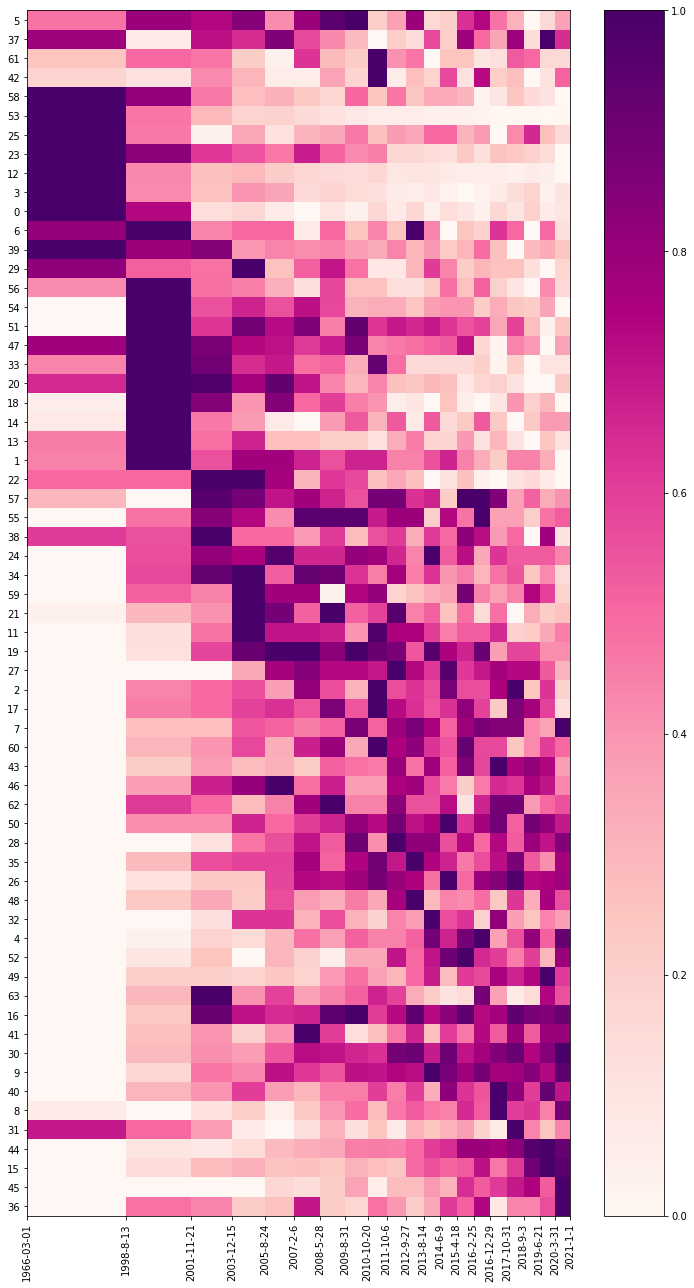

In [121]:
fig_name = 'fig6_1_tot_heatmap_original_lowess-order_xscaled_' + \
           f'no_globaltune_thr{thr}_sortSTRP.pdf'
plot_scaled_heatmap(tot_freq_ori_df, fig_name)

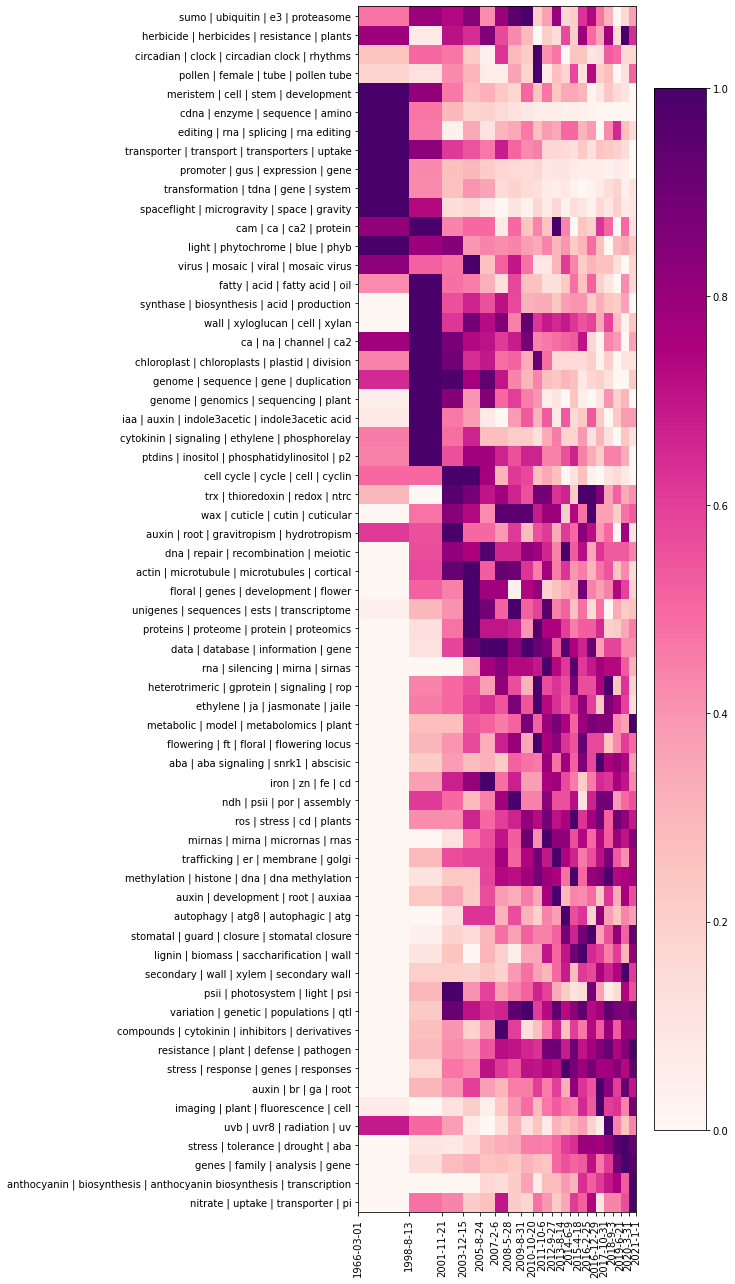

In [122]:
fig_name2 = 'fig6_1_tot_heatmap_original_lowess-order_xscaled_' + \
           f'no_globaltune_thr{thr}_sortSTRP_modnames.pdf'
plot_scaled_heatmap(tot_freq_ori_df, fig_name2, yticklabels_modnames)

## ___Testing___

In [123]:
d = datetime.strptime('20180131', '%Y%m%d').date()
d

datetime.date(2018, 1, 31)

In [124]:
d - relativedelta(years=1)

datetime.date(2017, 1, 31)

In [125]:
bin_dates[1]

datetime.datetime(1998, 8, 14, 0, 0)

In [126]:
bin_dates[1] - relativedelta(years=10)

datetime.datetime(1988, 8, 14, 0, 0)